In [1]:
# %matplotlib notebook
%matplotlib inline

In [2]:
import tomopy
import svmbir
import math
import dxchange
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import bm3d_streak_removal as bm3d_rmv
from imars3d.filters import tilt
# import logging
# logging.basicConfig(level=logging.INFO)

olefile module not found
/SNS/users/y9z/anaconda3/envs/rockit/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_ind_list(name_list:list):
    ind = []
    ang_deg = []
    ang_rad = []
    ind_dict_random = {}
    ind_dict_sorted = {}
    for e_name in name_list:
        _split = e_name.split('_')
        _index_tiff = _split[-1]
        _index = _index_tiff.split('.')[0]
        _ang = _split[-3] + '.' + _split[-2]
        index = int(_index)
        angle = float(_ang)
        ind.append(index)
        ang_deg.append(angle)
        ang_rad.append(math.radians(angle))
        ind_dict_random[index] = e_name
    ind = sorted(ind)
    for n, e_ind in enumerate(ind):
        ind_dict_sorted[n] = ind_dict_random[e_ind]
    
    return list(ind_dict_sorted.values()), (sorted(ang_deg)), np.array(sorted(ang_rad)), ind

def get_list(name_list:list):
    ind = []
    ind_dict_random = {}
    ind_dict_sorted = {}
    for e_name in name_list:
        _split = e_name.split('_')
        _index_tiff = _split[-1]
        _index = _index_tiff.split('.')[0]
        index = int(_index)
        ind.append(index)
        ind_dict_random[index] = e_name
    ind = sorted(ind)
    for n, e_ind in enumerate(ind):
        ind_dict_sorted[n] = ind_dict_random[e_ind]
    
    return list(ind_dict_sorted.values()), ind

def _init_arr_from_stack(fname, number_of_files, slc=None):
    """
    Initialize numpy array from files in a folder.
    """
    _arr = dxchange.read_tiff(fname, slc)
    size = (number_of_files, _arr.shape[0], _arr.shape[1])
    return np.empty(size, dtype=_arr.dtype)

def read_tiff_stack(fdir, fname:list):
    arr = _init_arr_from_stack(os.path.join(fdir, fname[0]), len(fname))
    for m, name in enumerate(fname):
        arr[m] = dxchange.read_tiff(os.path.join(fdir, name))
    return arr

def find_proj180_ind(ang_list:list):
    dif = [abs(x-180) for x in ang_list]
    difmin = min(dif)
    ind180 = dif.index(difmin)
    return (ind180, ang_list[ind180])

def shrink_window(corners, size):
    corners[0][0] = corners[0][0] + size
    corners[0][1] = corners[0][1] + size
    corners[1][0] = corners[1][0] + size
    corners[1][1] = corners[1][1] - size
    corners[2][0] = corners[2][0] - size
    corners[2][1] = corners[2][1] - size
    corners[3][0] = corners[3][0] - size
    corners[3][1] = corners[3][1] + size
    return corners

def set_roi(corners, xmin, ymin, xmax, ymax):
    corners[0][0] = xmin
    corners[0][1] = ymin
    corners[1][0] = xmin
    corners[1][1] = ymax
    corners[2][0] = xmax
    corners[2][1] = ymax
    corners[3][0] = xmax
    corners[3][1] = ymin
    return corners

################################################ Added on 8/24/2022

def is_routine_ct(ct_dir):
    re_list = []
    for each in ["raw*", "ct*", "ob*", "OB*", "dc*", "DC*", "df*", "DF*"]:
        re = len(glob.glob(ct_dir + "/" + each)) == 0
        re_list.append(re)
    if False in re_list:
        return False
    else:
        return True
def get_name_and_idx(fdir):
    fname_list = os.listdir(fdir)
    fname, idx_list = get_list(fname_list)
    return fname, idx_list
    
def load_ct(fdir, ang1=0, ang2=360, name="raw*"):
    if is_routine_ct(fdir):
        ct_list = os.listdir(fdir)
        ct_name, ang_deg, theta, idx_list = get_ind_list(ct_list)
    else:
        ct_list = glob.glob(fdir+"/"+name)
        ct_name, idx_list = get_list(ct_list)
        theta = tomopy.angles(len(idx_list), ang1=ang1, ang2=ang2) # Default 360 degree rotation
        ang_deg = np.rad2deg(theta)
    proj180_ind = find_proj180_ind(ang_deg)[0]
    print('Found index of 180 degree projections: ', proj180_ind)
    print('Loading CT projections...')
    proj = read_tiff_stack(fdir=ct_dir, fname=ct_name)
    print(proj.shape)
    plt.imshow(proj[0])
    plt.colorbar()
    plt.show()
    return proj, theta, proj180_ind
    
def load_ob(fdir, name="ob*"):
    if is_routine_ct(fdir):
        ob_name, idx_list = get_name_and_idx(fdir)
    else:
        ob_list = glob.glob(fdir+"/"+name)
        ob_name, idx_list = get_list(ob_list)
    print("Loading Open Beam (OB)...")
    ob = read_tiff_stack(fdir=fdir, fname=ob_name)
    print(ob.shape)
    plt.imshow(ob[0])
    plt.colorbar()
    plt.show()
    return ob

def load_dc(fdir, name="dc*"):
    if is_routine_ct(fdir):
        dc_name, idx_list = get_name_and_idx(fdir)
    else:
        dc_list = glob.glob(fdir+"/"+name)
        dc_name, idx_list = get_list(dc_list)
    print("Loading Dark Current (DC)...")
    dc = read_tiff_stack(fdir=fdir, fname=dc_name)
    print(dc.shape)
    plt.imshow(dc[0])
    plt.colorbar()
    plt.show()
    return dc

def remove_ring(proj, algorithm="Vo"):
    if algorithm == "Vo":
        proj_rmv = tomopy.prep.stripe.remove_all_stripe(proj)
    elif algorithm == "bm3d":
        proj_norm = bm3d_rmv.extreme_streak_attenuation(proj)
        proj_rmv = bm3d_rmv.multiscale_streak_removal(proj_norm)
    return proj_rmv


def recon(proj, theta, rot_center, algorithm="gridrec"):
    if algorithm == "svMBIR":
        # T, P, sharpness, snr_db: parameters of reconstruction, usually keep fixed. (Can be played with)
        T = 2.0
        p = 1.2
        sharpness = 0.0
        snr_db = 30.0
        center_offset= -(proj.shape[2]/2 - rot_center)
        recon = svmbir.recon(proj, angles=theta, weight_type='transmission',
                             center_offset=center_offset, 
                             snr_db=snr_db, p=p, T=T, sharpness=sharpness, 
                             positivity=False, max_iterations=100, 
                             num_threads= 112, verbose=0) # verbose: display of reconstruction: 0 is minimum, 1 is regular
    else:
        recon = tomopy.recon(proj, theta, center=rot_center, algorithm=algorithm, sinogram_order=False)
    recon = tomopy.circ_mask(recon, axis=0, ratio=1)
    return recon
        

# Workflow starts here!

In [4]:
###################### need to change start
ipts="23788"
###################### need to change end

## Find CT scan location

In [5]:
ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ct_scans"
os.listdir(ct_loc)

['2021_08_17_HEA',
 'Nov16_2019',
 'Aug20_2020',
 '2021_04_22',
 'Nov14_2019',
 'Oct30_2019',
 'Oct29_2019',
 'Nov17_2019',
 'Aug24_2020',
 '2021_08_14_plastic_2nd_resume',
 'June29_2020',
 'Aug19_2020',
 '2021_08_14_plastic_2nd',
 'July01_2020',
 '2021_09_03_gold_ore_wim',
 '2021_08_11_plastic',
 'Feb10_2020']

## Find OB location

In [6]:
ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ob"
os.listdir(ob_loc)

['2021_08_19_shale',
 'Nov15_2019',
 'Dec19_2019',
 '2021_08_17_HEA',
 'Dec18_2019',
 'Aug20_2020',
 '2021_04_22',
 'Nov14_2019',
 '2021_03_25',
 'Oct30_2019',
 'Oct29_2019',
 'Nov17_2019',
 'Aug24_2020',
 'December26_2019',
 'June29_2020',
 '2021_09_02_coin_cell_Maha',
 '2021_08_14_zyla_1x_OB_11mm',
 '2021_08_14_zyla_1x_OB_16mm',
 'Aug19_2020',
 'July01_2020',
 '2021_09_03_gold_ore_wim',
 '2021_08_11_plastic',
 'June27_2020',
 '2021_03_25_plastic',
 'Feb10_2020']

## Find DC location

In [7]:
dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/df"
os.listdir(dc_loc)

['2021_08_19_shale',
 'Aug21_2020',
 'Dec19_2019',
 '2021_05_10_shutter_open',
 'Feb06_2020',
 'Oct29_2019',
 '2021_08_16_DF_high_res',
 '2021_08_19_zyla',
 'Aug24_2020',
 'December26_2019',
 'June29_2020',
 '2021_09_05',
 'Aug25_2020',
 '2021_08_27_DF_30s',
 'Nov12_2019',
 'July01_2020',
 'June27_2020',
 'July02_2020',
 'Feb11_2020',
 'Nov18_2019']

In [8]:
###################### need to change start
ct_dir = os.path.join(ct_loc, "Aug24_2020")
ob_dir = os.path.join(ob_loc, "Aug24_2020")
dc_dir = os.path.join(dc_loc, "Aug24_2020")
# ct_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# ob_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# dc_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
###################### need to change end

# Load all data files (CT, OB and DC)

Found index of 180 degree projections:  643
Loading CT projections...
(1290, 2048, 2048)


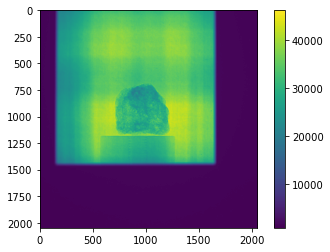

Loading Open Beam (OB)...
(10, 2048, 2048)


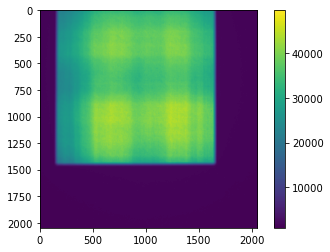

Loading Dark Current (DC)...
(10, 2048, 2048)


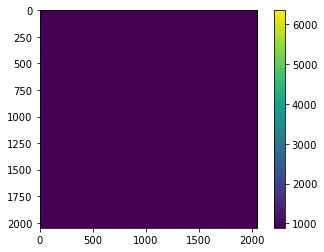

In [9]:
######### CT
proj, theta, proj180_ind = load_ct(ct_dir, ang2=360, name="raw*")
######### OB
ob = load_ob(ob_dir, name="ob*")
######### DC
dc = load_dc(dc_dir, name="df*")

# Define/crop ROI
## a. Auto detect and crop the slits

Slit corners: 
 [[ 136    0]
 [ 136 1466]
 [1658 1466]
 [1658    0]]
Projection at 0 degree:


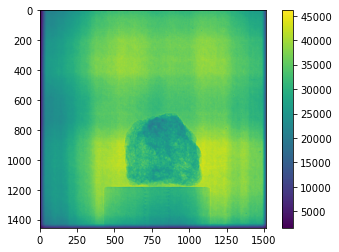

Projection at 180 degree:


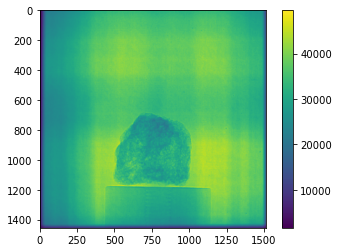

In [10]:
slit_box_corners = tomopy.prep.alignment.find_slits_corners_aps_1id(img=ob[0], method='simple')
print("Slit corners: \n", slit_box_corners)
proj_crop = tomopy.prep.alignment.remove_slits_aps_1id(proj, slit_box_corners)
ob_crop = tomopy.prep.alignment.remove_slits_aps_1id(ob, slit_box_corners)
dc_crop = tomopy.prep.alignment.remove_slits_aps_1id(dc, slit_box_corners)
print("Projection at 0 degree:")
plt.imshow(proj_crop[0])
plt.colorbar()
plt.show()
print("Projection at 180 degree:")
plt.imshow(proj_crop[proj180_ind])
plt.colorbar()
plt.show()

## b. Define the ROI by corners

Projection at 0 degree:


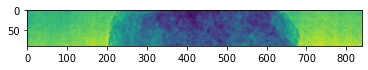

Projection at 180 degree:


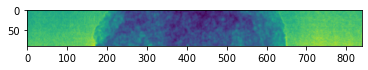

In [11]:
slit_box_corners = tomopy.prep.alignment.find_slits_corners_aps_1id(img=ob[0], method='simple')
roi_corners = set_roi(corners=slit_box_corners, xmin=500, ymin=800, xmax=1350, ymax=900)
proj_crop = tomopy.prep.alignment.remove_slits_aps_1id(proj, roi_corners)
ob_crop = tomopy.prep.alignment.remove_slits_aps_1id(ob, roi_corners)
dc_crop = tomopy.prep.alignment.remove_slits_aps_1id(dc, roi_corners)
print("Projection at 0 degree:")
plt.imshow(proj_crop[0])
plt.show()
print("Projection at 180 degree:")
plt.imshow(proj_crop[proj180_ind])
plt.show()

# Remove Outliers

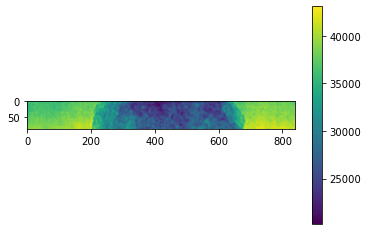

In [12]:
proj_crop = tomopy.misc.corr.remove_outlier(proj_crop, 50)
plt.imshow(proj_crop[0])
plt.colorbar()
plt.show()

# Normalization

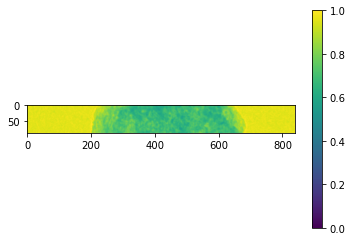

In [13]:
proj_norm = tomopy.normalize(proj_crop, ob_crop, dc_crop)
plt.imshow(proj_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

# Beam fluctuation correction (optional)

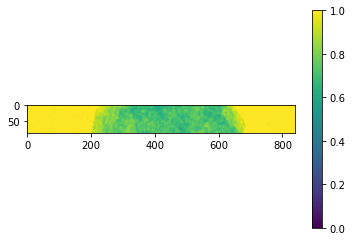

In [14]:
proj_norm = tomopy.prep.normalize.normalize_bg(proj_norm, air=50)
plt.imshow(proj_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()

# Filter NaN and negative

In [15]:
proj_norm = tomopy.remove_nan(proj_norm)
proj_norm = tomopy.remove_neg(proj_norm)

# Minus log conversion

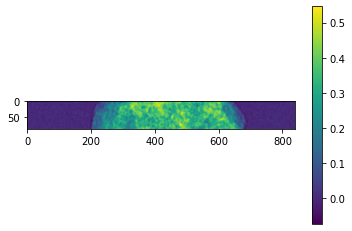

In [16]:
proj_mlog = tomopy.minus_log(proj_norm)
plt.imshow(proj_mlog[0])
plt.colorbar()
plt.show()

# Remove Outliers

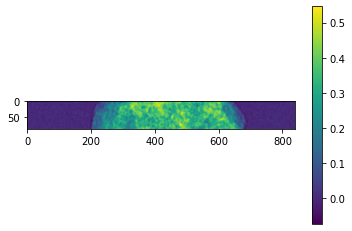

In [17]:
proj_mlog_filter = tomopy.remove_outlier(proj_mlog, 50)
plt.imshow(proj_mlog_filter[0])
plt.colorbar()
plt.show()

# Ring Artifact Removal

Before ring removal:


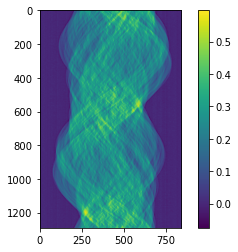

After ring removal:


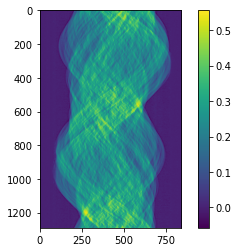

In [18]:
proj_rmv = remove_ring(proj_mlog_filter, algorithm="Vo")
# ############## bm3d, slightly better, but slow
# proj_rmv = remove_ring(proj_mlog_filter, algorithm="bm3d")
print("Before ring removal:")
plt.imshow(proj_mlog_filter[:, 80, :])
plt.colorbar()
plt.show()
print("After ring removal:")
plt.imshow(proj_rmv[:, 80, :])
plt.colorbar()
plt.show()

# Find and correct tilt

Finding the tilt angle...
Found the tilt angle:  -0.6587692390720613


/SNS/users/y9z/anaconda3/envs/rockit/lib/python3.10/site-packages/imars3d-0.1.3-py3.10.egg/imars3d/filters/tilt.py:115: TqdmWarning: Iterable length 1290 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
Applying tilt corr: 100%|█████████████████| 1290/1290 [00:01<00:00, 1271.86it/s]


Projection at 0 degree:


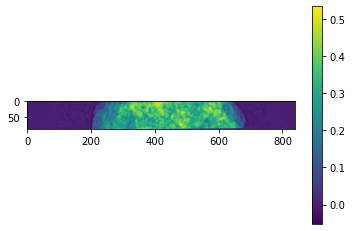

Projection at 180 degree:


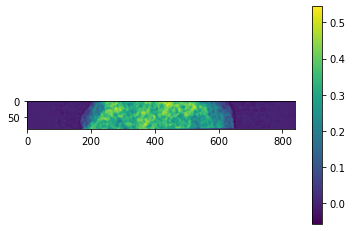

In [19]:
print("Finding the tilt angle...")
tilt_ang = tilt.calculate_tilt(image0=proj_rmv[0], image180=proj_rmv[proj180_ind])
print("Found the tilt angle: ", tilt_ang.x)
proj_tilt = tilt.apply_tilt_correction(proj_rmv, tilt_ang.x)
print("Projection at 0 degree:")
plt.imshow(proj_tilt[0])
plt.colorbar()
plt.show()
print("Projection at 180 degree:")
plt.imshow(proj_tilt[proj180_ind])
plt.colorbar()
plt.show()

# Find Center of Rotation

In [20]:
rot_center = tomopy.find_center_pc(np.squeeze(proj_tilt[0,:,:]), np.squeeze(proj_tilt[proj180_ind,:,:]), tol=0.5)
print('Estimated center of rotation:', rot_center)

Estimated center of rotation: 425.75


# Reconstruction

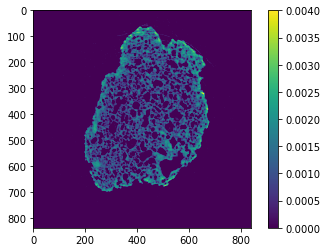

In [21]:
########## tomopy
recon = recon(proj_tilt, theta, rot_center=rot_center, algorithm='gridrec')
# ########## svMBIR
# recon = recon(proj_tilt, theta, rot_center=rot_center, algorithm='svMBIR')
plt.imshow(recon[80, :, :], vmax=0.004, vmin=0)
plt.colorbar()
plt.show()

# Export recon files

In [22]:
################ change save path for your own
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit_lava"
fname = save_to + "/recon" 
dxchange.write_tiff_stack(recon, fname=fname, overwrite=True)